In [5]:
#Importing Modules

from sklearn.model_selection import cross_val_predict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import roc_auc_score, f1_score

import warnings

#### Loading Data

In [6]:
#Combining the three datasets (under treatment, recovered and death) into one

df_1 = pd.read_excel('undertreatment.xlsx')
df_2 = pd.read_excel('recovered.xlsx')
df_3 = pd.read_excel('death.xlsx')

print('Shape of Undertreatment Data',df_1.shape,'Shape of recovered data', df_2.shape, 'Shape of death data', df_3.shape)

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

df.shape

Shape of Undertreatment Data (350, 30) Shape of recovered data (186, 30) Shape of death data (598, 30)


(1134, 30)

#### Data Preprocessing

In [7]:
#Printinf the datatype of each feature and target
df.dtypes

patient_id                               int64
gender                                   int64
education                                int64
treatment_data                           int64
id_healthcenter                          int64
id_treatment_region                      int64
hereditary_history                       int64
birth_date                              object
age                                      int64
weight                                   int64
thickness_tumor                        float64
marital_status                           int64
marital_length                          object
pregnency_experience                    object
giving_birth                            object
age_FirstGivingBirth                    object
\nabortion                              object
blood                                    int64
taking_heartMedicine                     int64
taking_blood_pressure_medicine           int64
taking_gallbladder_disease_medicine      int64
smoking      

In [8]:
#Renaming a few columns to make the dataset look neat
df.rename(columns = {"\nabortion": "abortion", "\nmenstrual_age":"menstrual_age", "\nmenopausal_age":"menopausal_age", 
                    "\nBenign_malignant_cancer":"Benign_malignant_cancer"}, inplace = True)

In [9]:
#checking for missing values
df.columns[df.isna().any()].tolist()

['menopausal_age']

In [10]:
#Using descriptive statistics of menopausal age to find replacement of missing values
df.menopausal_age.describe()

count    1132.000000
mean        0.114841
std         0.408866
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: menopausal_age, dtype: float64

In [11]:
#replacing missing values with zero
df['menopausal_age'] = df['menopausal_age'].fillna(0)

In [12]:
#confirming that there are no more missing values
df.columns[df.isna().any()].tolist()

[]

In [13]:
#Converting dataframe to string type 
df = df.astype(str)

counts = {}

# Looping through each column and count the number of "-" occurrences
for column in df.columns:
    count = (df[column] == '-').sum()
    if count > 0:  # check if count is greater than 0
        counts[column] = count
        print(f"Column '{column}' has {count} '-'")


Column 'marital_length' has 79 '-'
Column 'pregnency_experience' has 79 '-'
Column 'giving_birth' has 79 '-'
Column 'age_FirstGivingBirth  ' has 79 '-'
Column 'abortion' has 79 '-'


In [14]:
# replace "-" with NaN and drop all rows with NaN in place
df.replace('-', pd.NA, inplace=True)
df.dropna(inplace=True)

In [15]:
#Dropping irrelvant columns
cols_to_drop = ['patient_id', 'condition','birth_date']
df = df.drop(columns=cols_to_drop, axis = 1)

In [16]:
df = df.astype(float)

#### Data Visualisation

<AxesSubplot:>

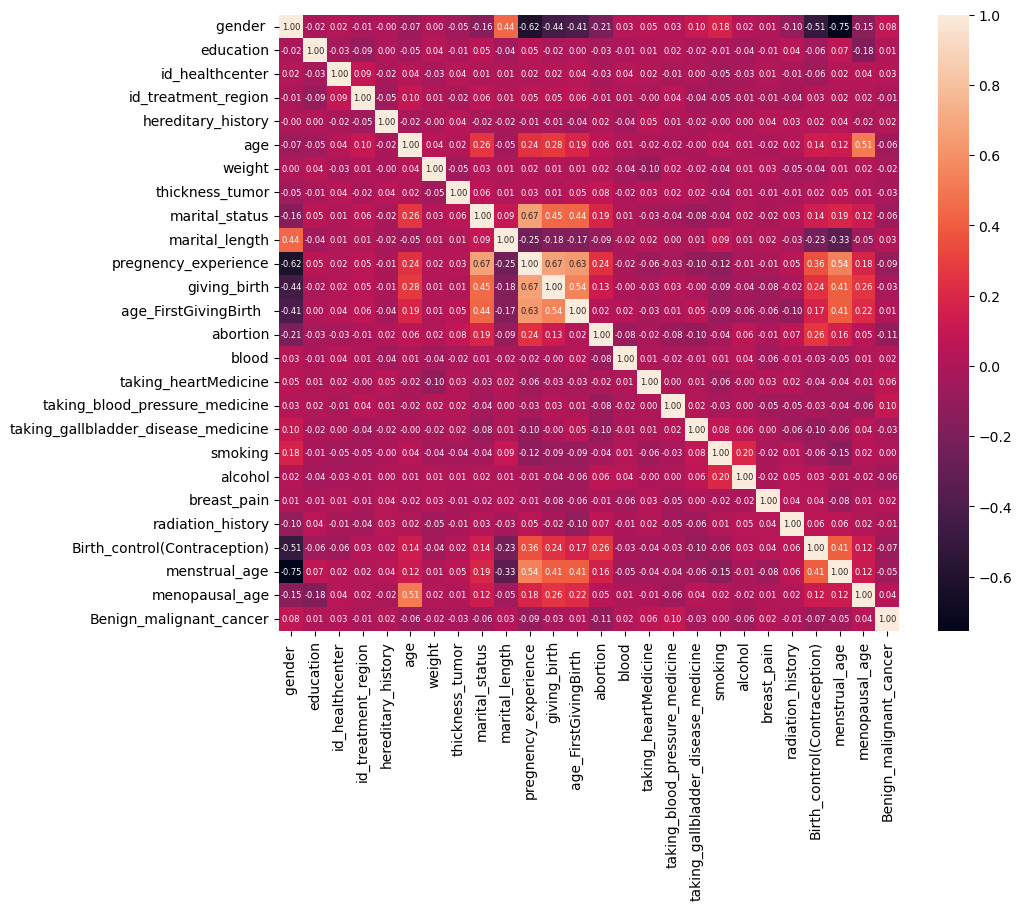

In [17]:
#dropping treatment_data as the year of treatment is 2019 for all
df = df.drop('treatment_data', axis = 1) 

#plotting heatmap
correlation_matrix = df.corr()
fig = plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", annot_kws={"size": 6})

Based on the heatmap, it appears that there is no strong correlation between the target and any of the features. Therefore, it may not be appropriate to use a linear regression model to analyze this dataset. Other modeling approaches, such as decision trees or support vector machines, which can handle non-linear relationships between variables, may be more suitable for this dataset. 

The following features have a strong correlation between each other

- gender & pregnancy_experience (-0.61)
- gender & menstural age (-0.75)
- age & menopausal age(0.51)
- pregnancy experience & marital status(0.67)
- pregnancy experience & giving birth (0.67 )
- pregnancy experience & age first giving birth(0.63)
- pregnancy experience & menstrual age(0.54)
- giving birth & age first giving birth (0.54)

Comparing the correlation of the above features with the target Benign Malignant Cancer

- gender (0.08)
- pregnancy experience (-0.09)
- age (-0.06)
- menopausal age (0.04)
- marital status (-0.06)
- giving birth (-0.03)
- age first giving birth(0.01)
- menstrual age (-0.05)



In [18]:
#Dropping columns to avoid multicolinearity 

df.drop(['gender ','menopausal_age', 'menstrual_age', 'marital_status', 'giving_birth', 'age_FirstGivingBirth  '], axis=1, inplace = True)

#Dropping id_healthcenter and id_treatment_region
df.drop(['id_healthcenter', 'id_treatment_region'], axis=1, inplace = True)

In [19]:
#checking for any imbalance in the dataset
target_counts = df["Benign_malignant_cancer"].value_counts()
print(target_counts)


1.0    651
0.0    401
2.0      3
Name: Benign_malignant_cancer, dtype: int64


In [20]:
#dropping rows where target is equal to 2
df = df[df['Benign_malignant_cancer'] != 2]

In [21]:
#initalising the Min-Max scalar function
scaler = MinMaxScaler()

In [22]:
#Scaling the dataset
scaled_data = scaler.fit_transform(df)


#### Training and Testing Dataset

In [23]:
#Splitting data into training and testing set

X = scaled_data[:, :-1]
y = scaled_data[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

#### Decision Trees

In [24]:
#Training and fitting with Decision Trees Forest

clf_dt = DecisionTreeClassifier()

In [25]:
#Running 5-fold cross Validation
k_folds = KFold(n_splits = 5)

# Perform cross-validation and obtain predicted probabilities and labels
y_scores_dt = cross_val_predict(clf_dt, x_train, y_train, cv=k_folds, method="predict_proba")[:, 1]
y_pred_dt = cross_val_predict(clf_dt, x_train, y_train, cv=k_folds)

# Calculate AUC
auc_dt = roc_auc_score(y_train, y_scores_dt)
f1_dt = f1_score(y_train, y_pred_dt)

#Calculating mean
scores_dt = cross_val_score(clf_dt, x_train , y_train, cv = k_folds)

print("Performance metrics of the Decision Tree Classifier are:\n")
print("Cross Validation Scores: ", scores_dt)
print("\nAverage CV Score: ", scores_dt.mean())
print("\nStandard Deviation is ", scores_dt.std())
print("\nArea under the curve:",auc_dt)
print("F1 score:",f1_dt)

Performance metrics of the Decision Tree Classifier are:

Cross Validation Scores:  [0.62130178 0.53571429 0.54761905 0.61904762 0.54761905]

Average CV Score:  0.5742603550295857

Standard Deviation is  0.037746820278579715

Area under the curve: 0.5378358925143955
F1 score: 0.6552053486150907


#### K Nearest Neighbour

In [26]:
#Training and fitting with KNN

clf_knn = KNeighborsClassifier(n_neighbors=3)

In [27]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
# Perform cross-validation and obtain predicted probabilities and labels
y_scores_knn = cross_val_predict(clf_knn, x_train, y_train, cv=k_folds, method="predict_proba")[:, 1]
y_pred_knn = cross_val_predict(clf_knn, x_train, y_train, cv=k_folds)

# Calculate AUC
auc_knn = roc_auc_score(y_train, y_scores_knn)
f1_knn = f1_score(y_train, y_pred_knn)

#Calculating mean
scores_knn = cross_val_score(clf_knn, x_train , y_train, cv = k_folds)

print("Performance metrics of the K-Nearest Neighbour are:\n")
print("Cross Validation Scores: ", scores_knn)
print("\nAverage CV Score: ", scores_knn.mean())
print("\nStandard Deviation is ", scores_knn.std())
print("\nArea under the curve:",auc_knn)
print("F1 score:",f1_knn)

Performance metrics of the K-Nearest Neighbour are:

Cross Validation Scores:  [0.50295858 0.54761905 0.5297619  0.5297619  0.55952381]

Average CV Score:  0.5339250493096646

Standard Deviation is  0.019164591767556655

Area under the curve: 0.48184980806142036
F1 score: 0.6370370370370371


#### Support Vector Machine

In [29]:
#Training and fitting with SVM

clf_svm = SVC(probability=True)

In [30]:
# Perform cross-validation and obtain predicted probabilities and labels
y_scores_svm = cross_val_predict(clf_svm, x_train, y_train, cv=k_folds, method="predict_proba")[:, 1]
y_pred_svm = cross_val_predict(clf_svm, x_train, y_train, cv=k_folds)

# Calculate AUC
auc_svm = roc_auc_score(y_train, y_scores_svm)
f1_svm = f1_score(y_train, y_pred_svm)

#Calculating mean
scores_svm = cross_val_score(clf_svm, x_train , y_train, cv = k_folds)

print("Performance metrics of the SVM are:\n")
print("Cross Validation Scores: ", scores_svm)
print("\nAverage CV Score: ", scores_svm.mean())
print("\nStandard Deviation is ", scores_svm.std())
print("\nArea under the curve:",auc_svm)
print("F1 score:",f1_svm)

Performance metrics of the SVM are:

Cross Validation Scores:  [0.59171598 0.57738095 0.5952381  0.63690476 0.58928571]

Average CV Score:  0.598105100028177

Standard Deviation is  0.02030628592527547

Area under the curve: 0.53010136756238
F1 score: 0.7351097178683386


#### Ensemble Method - Adaboost Classifier

In [31]:
# Define the AdaBoost classifier with 100 estimators
clf_ad = AdaBoostClassifier(base_estimator=clf_dt, n_estimators=100, random_state=42)

# Perform cross-validation and obtain predicted probabilities and labels
y_scores_ad = cross_val_predict(clf_ad, x_train, y_train, cv=k_folds, method="predict_proba")[:, 1]
y_pred_ad = cross_val_predict(clf_ad, x_train, y_train, cv=k_folds)

#Running 5-fold cross Validation

scores_ad = cross_val_score(clf_ad, x_train , y_train, cv = k_folds)

# Calculate AUC
auc_ad = roc_auc_score(y_train, y_scores_ad)
f1_ad = f1_score(y_train, y_pred_ad)

print("Performance metrics of the Adaboost with Decision Trees as base are:\n")
print("Cross Validation Scores: ", scores_ad)
print("\nAverage CV Score: ", scores_ad.mean())
print("\nStandard Deviation is ", scores_ad.std())
print("\nArea under the curve:",auc_ad)
print("F1 score:",f1_ad)

Performance metrics of the Adaboost with Decision Trees as base are:

Cross Validation Scores:  [0.62721893 0.51785714 0.5952381  0.61904762 0.56547619]

Average CV Score:  0.584967596506058

Standard Deviation is  0.03983926348629416

Area under the curve: 0.5631927783109405
F1 score: 0.661493695441319


#### Visualising the metrics for comparison

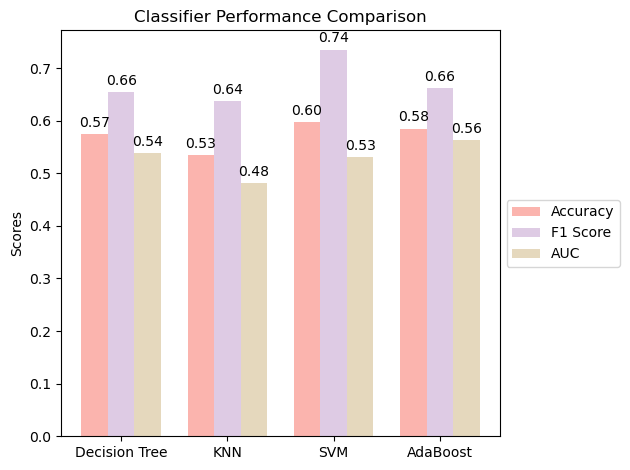

In [32]:
# List of classifiers and their performance metrics
classifiers = ['Decision Tree', 'KNN', 'SVM', 'AdaBoost']
accuracy = [scores_dt.mean(), scores_knn.mean(), scores_svm.mean(), scores_ad.mean()]
f1_score = [f1_dt, f1_knn, f1_svm, f1_ad]
auc = [auc_dt, auc_knn, auc_svm, auc_ad]

# Define colors for the bars
colors = plt.cm.Pastel1(np.linspace(0, 1, len(classifiers)))

# Plotting the metrics
x = np.arange(len(classifiers))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, accuracy, width, label='Accuracy', color = colors[0])
rects2 = ax.bar(x, f1_score, width, label='F1 Score', color = colors[1])
rects3 = ax.bar(x + width, auc, width, label='AUC', color = colors[2])

# Add value annotations
for rect in rects1:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects3:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Scores')
ax.set_title('Classifier Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()

# Move the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

#### Grid Search to fine-tune hyperparameters

In [33]:
# define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 0.5, 1],
              'kernel': ['linear','rbf']}

In [34]:
warnings.simplefilter(action='ignore', category=UserWarning)

In [35]:
# create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_svm, param_grid, cv=5)

# fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# print the best hyperparameters and the corresponding accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.62


In [36]:
#Tuning the classifier using Grid Search results
sv = SVC(C = 0.1, gamma = 0.1, kernel = 'rbf')

In [37]:
sv.fit(x_train, y_train)

SVC(C=0.1, gamma=0.1)

In [38]:
#Evaluating the performance on the test set
y_pred = sv.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy of the model is:', acc)

Accuracy of the model is: 0.6161137440758294
